Join the crash dataset to the street centerline dataset. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', 200)

In [2]:
denver_crs = 3502
web_crs = 4326

In [3]:
from crash_data_analysis import CrashDataAnalysis
cda = CrashDataAnalysis()
df = cda.crash_dataframe()

In [4]:
df = df[df.geo_lon.notnull()].reset_index().copy()

In [5]:
crashes = gpd.GeoDataFrame(
    data=df
    , geometry=gpd.points_from_xy(df['geo_lon'], df['geo_lat'])
    , crs=4326
)

In [6]:
# crashes = crashes.tail(100).copy()
crashes = crashes[crashes.reported_date.dt.strftime('%Y-%m') == '2022-07']

In [7]:
crashes[['street_a', 'street_b']] = crashes.incident_address.str.split('/', expand=True)
crashes['street_a'] = crashes['street_a'].str.strip()
crashes['street_b'] = crashes['street_b'].str.strip()

In [8]:
crashes['link'] = crashes.apply(
    lambda row: f'https://www.google.com/maps/search/?api=1&query={row.geo_lat},{row.geo_lon}', axis=1
)

In [9]:
centerlines = gpd.read_file('shapefiles/street_centerline/street_centerline.shp')

In [10]:
centerlines = centerlines[centerlines['FULLNAME'] != 'PRIVATE RD'].reset_index().copy()

In [11]:
centerlines = centerlines.to_crs(denver_crs)
crashes = crashes.to_crs(denver_crs)

In [12]:
offset = 35 # feet
bbox = crashes.bounds + [-offset, -offset, offset, offset]

In [13]:
hits = bbox.apply(lambda row: list(centerlines.sindex.intersection(row)), axis=1)

In [14]:
crashes_streets_list = []

for crash_index, row in tqdm(hits.iteritems(), total=len(hits)):
    for street_index in row:
        new_row = [
            crashes.loc[crash_index].incident_id
            , centerlines.loc[street_index].MASTERID
        ]
        
        crashes_streets_list += [new_row]

crashes_streets = pd.DataFrame(crashes_streets_list, columns=['incident_id', 'MASTERID'])

100%|██████████| 767/767 [00:01<00:00, 495.08it/s]


In [15]:
# for street in hits[212222]:
#     print('{}: {} from {} to {}'.format(
#         centerlines.loc[street].MASTERID
#         , centerlines.loc[street].FULLNAME
#         , centerlines.loc[street].FROMNAME
#         , centerlines.loc[street].TONAME
#     ))

In [16]:
crashes_streets = pd.merge(crashes_streets, crashes, how='inner', on='incident_id')
crashes_streets = pd.merge(crashes_streets, centerlines, how='inner', on='MASTERID')

In [17]:
incident_mapping = {
    'N BIGHTON BLVD': 'N BRIGHTON BLVD'
    , 'I25 HWYNB': 'INTERSTATE 25'
    , 'I25 HWYSB': 'INTERSTATE 25'
    , 'I25HWY': 'INTERSTATE 25'
    , 'I70 HWYWB': 'INTERSTATE 70'
    , 'I70 HWYEB': 'INTERSTATE 70'
    , 'I225 HWYNB': 'INTERSTATE 225'
    , 'I225 HWYSB': 'INTERSTATE 225'
    , 'W 6TH AVE': 'W 6TH AVENUE FWY'
    , 'PARK AVEW': 'PARK AVE W'
    , 'S MONACO ST': 'S MONACO STREET PKWY'
    , 'N MONACO ST': 'N MONACO STREET PKWY'
    , 'E MLK BLVD': 'E MARTIN LUTHER KING BLVD'
    , 'E MARTIN LUTHER KING BLVD': 'E MARTIN LUTHER KING JR BLVD'
    , 'E GVR BLVD': 'GREEN VALLEY RANCH BLVD'
}
crashes_streets['incident_address_corrected'] = crashes_streets.incident_address.replace(incident_mapping, regex=True)

In [18]:
crashes_streets['street_named_in_crash'] = crashes_streets.apply(
    lambda row: row.FULLNAME in row.incident_address_corrected, axis=1)

In [19]:
freeways = [
    'INTERSTATE 25'
    , 'INTERSTATE 70'
    , 'INTERSTATE 225'
    , 'W 6TH AVENUE FWY'
]
crashes_streets['at_freeway'] = False

for f in freeways:
    crashes_streets.loc[crashes_streets.incident_address_corrected.str.contains(f), 'at_freeway'] = True

In [20]:
bad_mapping = crashes_streets[~crashes_streets.street_named_in_crash][
    ['incident_address_corrected', 'FULLNAME', 'link']
]

In [21]:
most_common = bad_mapping.groupby('FULLNAME').size().sort_values(ascending=False)
# most_common.head(20)

In [22]:
# bad_mapping[bad_mapping.FULLNAME == 'E MARTIN LUTHER KING JR BLVD']

In [23]:
pd.pivot_table(
    data=crashes_streets
    , index='street_named_in_crash'
    , columns='at_freeway'
    , values='one'
    , aggfunc=sum
    , margins=True
)

at_freeway,False,True,All
street_named_in_crash,,,
False,274,135,409
True,1690,495,2185
All,1964,630,2594


In [24]:
# crashes_streets.to_csv('crashes_streets.csv', index=False)

## Analysis

In [25]:
street_counts = crashes_streets[
    (crashes_streets.street_named_in_crash) & ~(crashes_streets.at_freeway)
].groupby('FULLNAME').agg(
    num_crashes=('incident_id', pd.Series.nunique)
)

street_counts['crashes_per_week'] = (street_counts['num_crashes'] / 31) * 7

In [26]:
street_miles = pd.DataFrame(centerlines.groupby('FULLNAME').LEN_MI.sum()).reset_index()

In [27]:
street_counts_miles = pd.merge(street_counts, street_miles, how='inner', on='FULLNAME')

In [28]:
street_counts_miles['crashes_per_week_per_mile'] = (
    street_counts_miles['crashes_per_week'] / street_counts_miles['LEN_MI']
)

In [29]:
most_crashes = street_counts_miles[street_counts_miles['crashes_per_week'] > 2].copy()

In [30]:
most_crashes['street_rank'] = most_crashes['crashes_per_week_per_mile'].rank(ascending=False)

In [31]:
most_crashes.sort_values(by='crashes_per_week_per_mile', ascending=False)

,FULLNAME,num_crashes,crashes_per_week,LEN_MI,crashes_per_week_per_mile,street_rank
70,E COLFAX AVE,17,3.838710,5.544884,0.692298,1.0
232,S COLORADO BLVD,12,2.709677,4.363691,0.620960,2.0
168,N LINCOLN ST,9,2.032258,3.344696,0.607606,3.0
143,N FEDERAL BLVD,17,3.838710,7.419015,0.517415,4.0
29,E 17TH AVE,9,2.032258,3.979629,0.510665,5.0
314,W ALAMEDA AVE,9,2.032258,4.027947,0.504539,6.0
129,N COLORADO BLVD,15,3.387097,7.150603,0.473680,7.0
76,E EVANS AVE,12,2.709677,5.785197,0.468381,8.0
270,S SANTA FE DR,11,2.483871,5.378060,0.461853,9.0
121,N BROADWAY,9,2.032258,4.509889,0.450623,10.0


In [32]:
# centerlines[centerlines['FULLNAME'] == 'N SPEER BLVD'].to_clipboard()

In [33]:
# crashes.groupby('street_a').size().sort_values(ascending=False)

## Measure Street Length from Crash Locations 

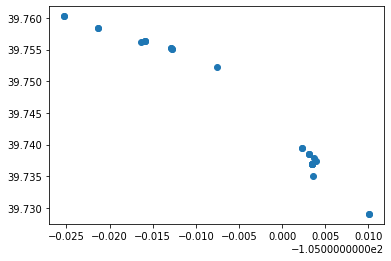

In [34]:
data_to_plot = crashes_streets[crashes_streets.FULLNAME == 'N SPEER BLVD']

plt.scatter(
    x=data_to_plot.geo_lon
    , y=data_to_plot.geo_lat
)

In [35]:
# crashes_streets[crashes_streets.FULLNAME == 'N PEORIA ST'].to_clipboard()

In [36]:
crashes.incident_address.str.contains('PARK AVEW').sum()

10